In [327]:
import pymc as pm
from pymc import do
import arviz as az
import numpy as np
from scipy.stats import gaussian_kde

---
# Draft Model

## Import dependencies

In [328]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

## Generate mock data for the test

In [329]:
np.random.seed(42)
N = 10
df_test = pd.DataFrame({
    "researc_dev": np.random.lognormal(mean=3, sigma=2, size=N),
    "ad_spend": np.random.lognormal(mean=4, sigma=1, size=N),
    "tech_perception": np.random.beta(a=2, b=3, size=N),
    "eco_perception": np.random.beta(a=3, b=2, size=N),
    "ventes": np.random.lognormal(mean=np.log(np.random.lognormal(mean=6, sigma=2, size=N)) + np.log(np.random.lognormal(mean=2, sigma=1, size=N)), sigma=0.5, size=N)
})

In [330]:
df_test

,researc_dev,ad_spend,tech_perception,eco_perception,ventes
0,54.240524,34.349323,0.653481,0.397469,64216.628245
1,15.233111,34.269997,0.270598,0.597858,8150.596534
2,73.359871,69.544183,0.311869,0.538900,1181.296974
3,422.445191,8.058438,0.561979,0.576539,6340.575239
4,12.574780,9.728718,0.724644,0.507414,336.769510
5,12.575193,31.115699,0.136094,0.773868,13405.062600
6,472.683311,19.829463,0.487603,0.361244,535.550077
7,93.211347,74.757335,0.408384,0.682196,2378.010503
8,7.854222,22.020546,0.192158,0.516937,1051.862309
9,59.449076,13.299099,0.504169,0.585443,278.048242


In [331]:
df_test.researc_dev.mean()

122.36266267036517

In [332]:
df_test.ad_spend.mean()

31.697280085409595

## Declare the model

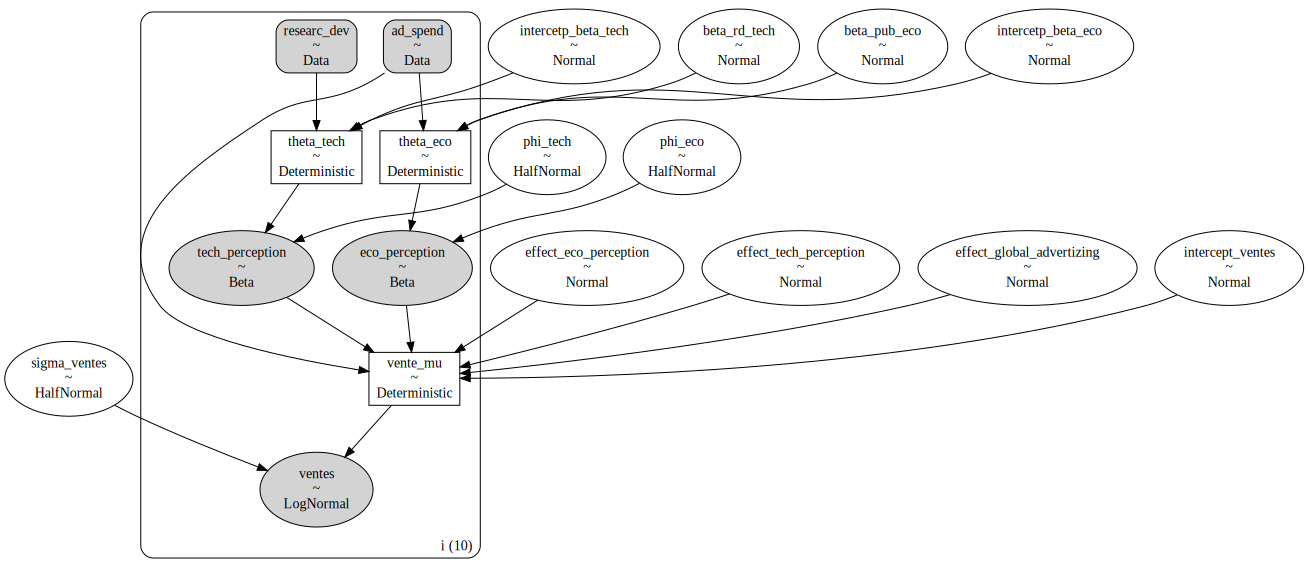

In [333]:
# Modèle de réseau bayésien
with pm.Model(coords={"i": np.arange(N)}) as model:
    # Define priors for parent nodes
    researc_dev = pm.Data('researc_dev', df_test["researc_dev"].values, dims="i")
    ad_spend = pm.Data('ad_spend', df_test["ad_spend"].values, dims="i")

    # Define the model parameters prior for the beta reg of R&D on tech.
    intercetp_beta_tech = pm.Normal('intercetp_beta_tech')
    beta_rd_tech = pm.Normal('beta_rd_tech')
    phi_tech = pm.HalfNormal('phi_tech')
    mu_tech = intercetp_beta_tech + beta_rd_tech * researc_dev
    theta_tech = pm.Deterministic('theta_tech', pm.math.invlogit(mu_tech), dims="i")

    # Define the model parameters prior for the beta reg of pub on eco.
    intercetp_beta_eco = pm.Normal('intercetp_beta_eco')
    beta_pub_eco = pm.Normal('beta_pub_eco')
    phi_eco = pm.HalfNormal('phi_eco')
    mu_eco = intercetp_beta_eco + beta_pub_eco * ad_spend
    theta_eco = pm.Deterministic('theta_eco', pm.math.invlogit(mu_eco), dims="i")

    # Beta likelihood for observed data y
    tech_perception = pm.Beta('tech_perception', alpha=theta_tech * phi_tech, beta=(1 - theta_tech) * phi_tech, dims="i", observed=df_test["tech_perception"].values)
    eco_perception = pm.Beta('eco_perception', alpha=theta_eco * phi_eco, beta=(1 - theta_eco) * phi_eco, dims="i", observed=df_test["eco_perception"].values)

    # Final sur les ventes
    intercept_ventes = pm.Normal('intercept_ventes')
    effect_tech_perception = pm.Normal('effect_tech_perception')
    effect_eco_perception = pm.Normal('effect_eco_perception')
    effect_global_advertizing = pm.Normal('effect_global_advertizing')
    sigma_ventes = pm.HalfNormal("sigma_ventes")
    vente_mu = pm.Deterministic("vente_mu", intercept_ventes + (effect_tech_perception * tech_perception) +
                                (effect_eco_perception * eco_perception) +
                                (effect_global_advertizing * ad_spend), dims="i")
    ventes = pm.LogNormal("ventes", mu=vente_mu, sigma=sigma_ventes, dims="i", observed=df_test["ventes"].values)

pm.model_to_graphviz(model)

## Fit the model

In [334]:
with model:
    idata = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercetp_beta_tech, beta_rd_tech, phi_tech, intercetp_beta_eco, beta_pub_eco, phi_eco, intercept_ventes, effect_tech_perception, effect_eco_perception, effect_global_advertizing, sigma_ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 374 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


## Check the trace to assess convergence

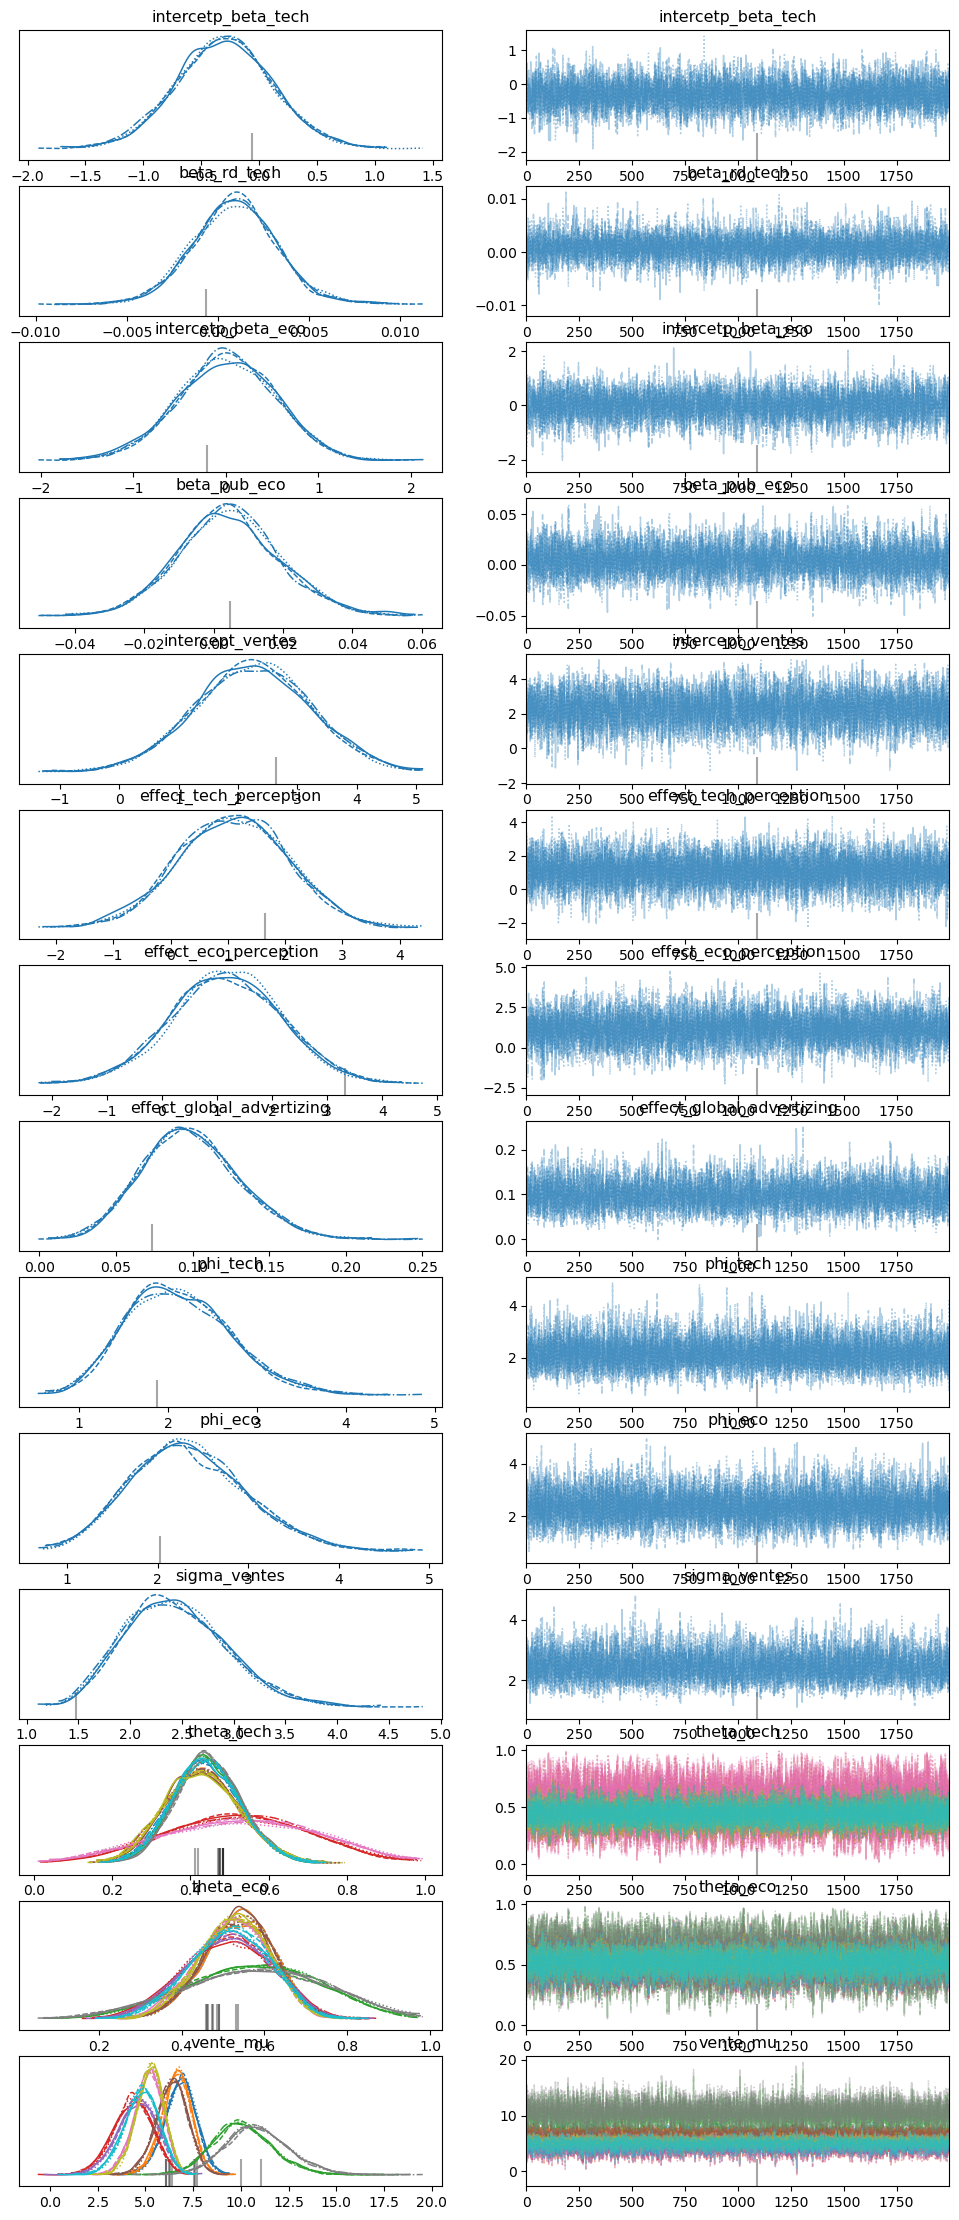

In [253]:
az.plot_trace(idata)
plt.show()


In [260]:
# Afficher les résumés des paramètres
#az.summary(idata)

### Select a subset of parameters to check more in detail - specifically the one in the structural equation - intermediary params are les interesting 

In [268]:

variables_a_afficher = [
    "intercetp_beta_tech",
    "beta_rd_tech",
    "intercetp_beta_eco",
    "beta_pub_eco",
    "intercept_ventes",
    "effect_tech_perception",
    "effect_eco_perception",
    "effect_global_advertizing"
]

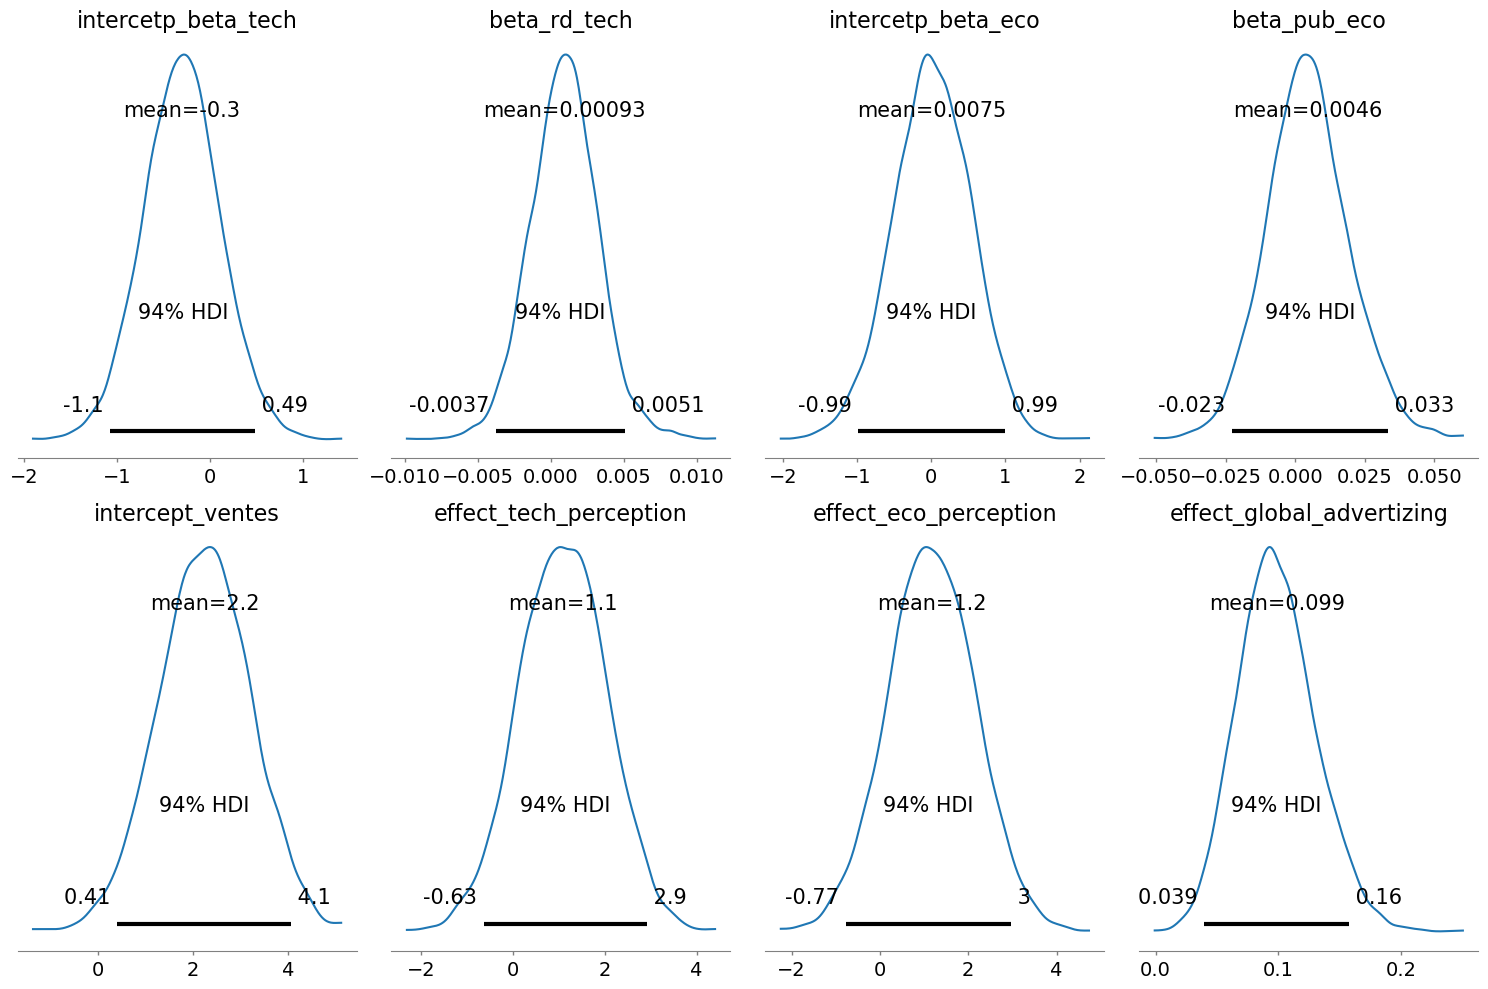

In [269]:
az.plot_posterior(
    idata,
    var_names=variables_a_afficher,
    figsize=(15, 10)  # Ajustez la taille en fonction du nombre de variables
)
plt.tight_layout();

## Sample data based on parameters posterior distribution to generate sales data

In [257]:
with model:
    # Générer des échantillons prédictifs postérieurs pour 'ventes'
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=["ventes"], random_seed=42)

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### plot these Y data as a K Density Plot

In [258]:
ventes_pred = posterior_predictive.posterior_predictive["ventes"]
ventes_pred_array = ventes_pred.values
ventes_pred_flat = ventes_pred_array.flatten()

80000

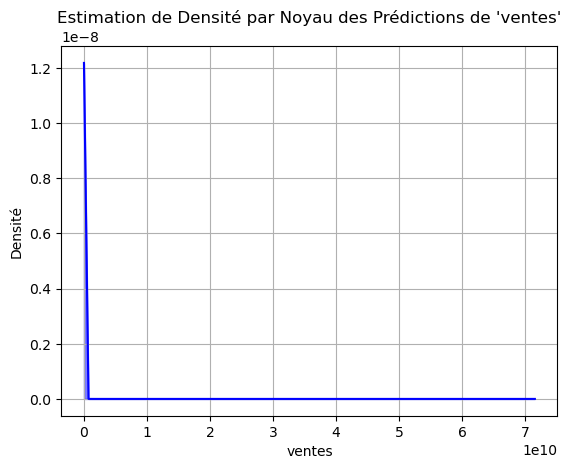

In [259]:
# Calculer le KDE
kde = gaussian_kde(ventes_pred_flat, bw_method='scott')  # bw_method peut être ajusté

# Créer une grille de points sur laquelle évaluer le KDE
x_grid = np.linspace(min(ventes_pred_flat), max(ventes_pred_flat), 100)

# Calculer les valeurs KDE sur la grille de points
kde_values = kde.evaluate(x_grid)

# Tracer le KDE avec matplotlib
plt.plot(x_grid, kde_values, color='blue')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='blue')
plt.title("Estimation de Densité par Noyau des Prédictions de 'ventes'")
plt.xlabel("ventes")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

## Generate new parameters predictions after imputing new data

In [299]:
# Nouvelles données pour les noeuds sans parents
researc_dev_downgrade = np.array([10, 12, 8, 9, 15, 18, 14, 89, 60, 13])  # Exemple de nouvelles données
ad_spend_downgrade = np.array([3, 5, 4, 6, 7, 2, 2, 8, 6, 7])         # Exemple de nouvelles données

# Mise à jour des valeurs pour les noeuds sans parents dans le modèle
with model:
    pm.set_data({"researc_dev": researc_dev_downgrade, "ad_spend": ad_spend_downgrade})
    # Générer des échantillons prédictifs pour les nouvelles données
    new_posterior_predictive_downgrade = pm.sample_posterior_predictive(idata, var_names=["tech_perception", "eco_perception","ventes"], random_seed=42)

# Accéder aux nouvelles prédictions pour 'ventes'
new_ventes_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["ventes"]
new_perception_eco_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["eco_perception"]
new_perception_tech_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["tech_perception"]

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [300]:
ventes_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["ventes"]
ventes_pred_downgrade_array = ventes_pred_downgrade.values
ventes_pred_downgrade_flat = ventes_pred_downgrade_array.flatten()

perception_eco_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["eco_perception"]
perception_eco_pred_downgrade_array = perception_eco_pred_downgrade.values
perception_eco_pred_downgrade_flat = perception_eco_pred_downgrade_array.flatten()

perception_tech_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["tech_perception"]
perception_tech_pred_downgrade_array = perception_tech_pred_downgrade.values
perception_tech_pred_downgrade_flat = perception_tech_pred_downgrade_array.flatten()

In [301]:
# Nouvelles données pour les noeuds sans parents
researc_dev_cst = np.array([122, 122, 122, 122, 122, 122, 122, 122, 122, 122])  # Exemple de nouvelles données
ad_spend_cst = np.array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36])         # Exemple de nouvelles données

# Mise à jour des valeurs pour les noeuds sans parents dans le modèle
with model:
    pm.set_data({"researc_dev": researc_dev_cst, "ad_spend": ad_spend_cst})
    # Générer des échantillons prédictifs pour les nouvelles données
    new_posterior_predictive_cst = pm.sample_posterior_predictive(idata, var_names=["tech_perception", "eco_perception", "ventes"], random_seed=42)

# Accéder aux nouvelles prédictions pour 'ventes'
new_ventes_pred_cst = new_posterior_predictive_cst.posterior_predictive["ventes"]
new_perception_eco_pred_cst = new_posterior_predictive_cst.posterior_predictive["eco_perception"]
new_perception_tech_pred_cst = new_posterior_predictive_cst.posterior_predictive["tech_perception"]

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [302]:
ventes_pred_cst = new_posterior_predictive_cst.posterior_predictive["ventes"]
ventes_pred_cst_array = ventes_pred_cst.values
ventes_pred_cst_flat = ventes_pred_cst_array.flatten()

perception_eco_pred_cst = new_posterior_predictive_cst.posterior_predictive["eco_perception"]
perception_eco_pred_cst_array = perception_eco_pred_cst.values
perception_eco_pred_cst_flat = perception_eco_pred_cst_array.flatten()

perception_tech_pred_cst = new_posterior_predictive_cst.posterior_predictive["tech_perception"]
perception_tech_pred_cst_array = perception_tech_pred_cst.values
perception_tech_pred_cst_flat = perception_tech_pred_cst_array.flatten()

## Make the difference between the two predictions before and after adding data and check the difference for effect size

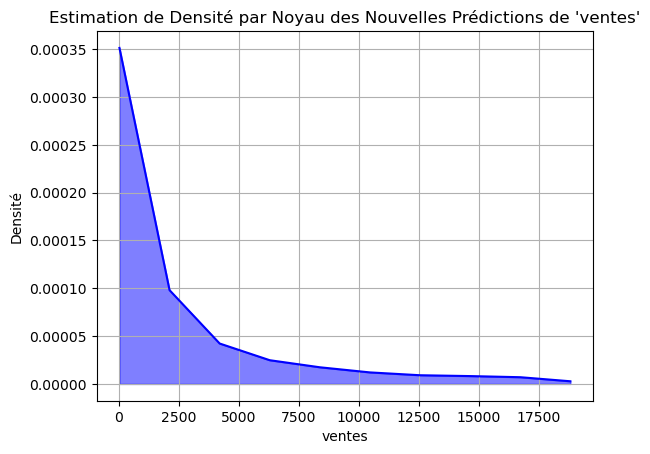

In [309]:
difference = ventes_pred_cst_flat - ventes_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='blue')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='blue')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'ventes'")
plt.xlabel("ventes")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

In [295]:
print(diff_filtered.min())
print(diff_filtered.mean())
print(diff_filtered.max())

37.416972273536
2682.887608739096
18806.26907593956


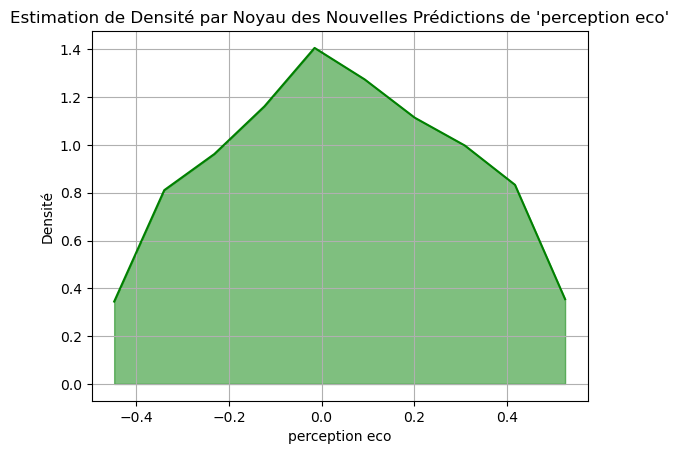

In [311]:
difference = perception_eco_pred_cst_flat - perception_eco_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='green')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='green')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'perception eco'")
plt.xlabel("perception eco")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

In [312]:
print(diff_filtered.min())
print(diff_filtered.mean())
print(diff_filtered.max())

-0.44722066035288394
0.039103796304151194
0.5245764578724474


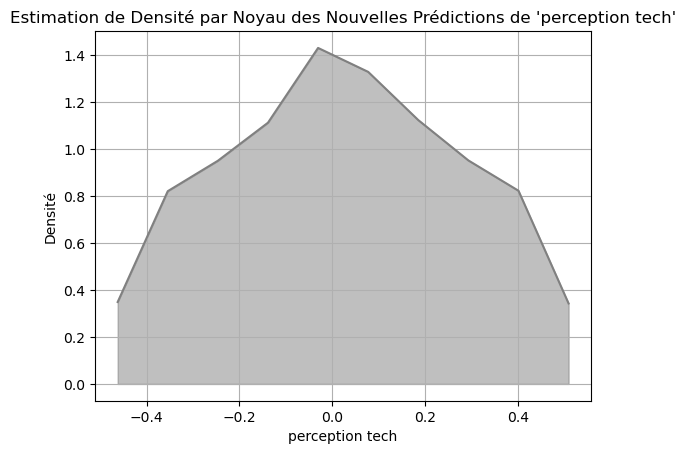

In [313]:
difference = perception_tech_pred_cst_flat - perception_tech_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='grey')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='grey')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'perception tech'")
plt.xlabel("perception tech")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

In [314]:
print(diff_filtered.min())
print(diff_filtered.mean())
print(diff_filtered.max())

-0.46231007329368373
0.022721420815897973
0.5092828065921267


---
# On tente un truc foutoir

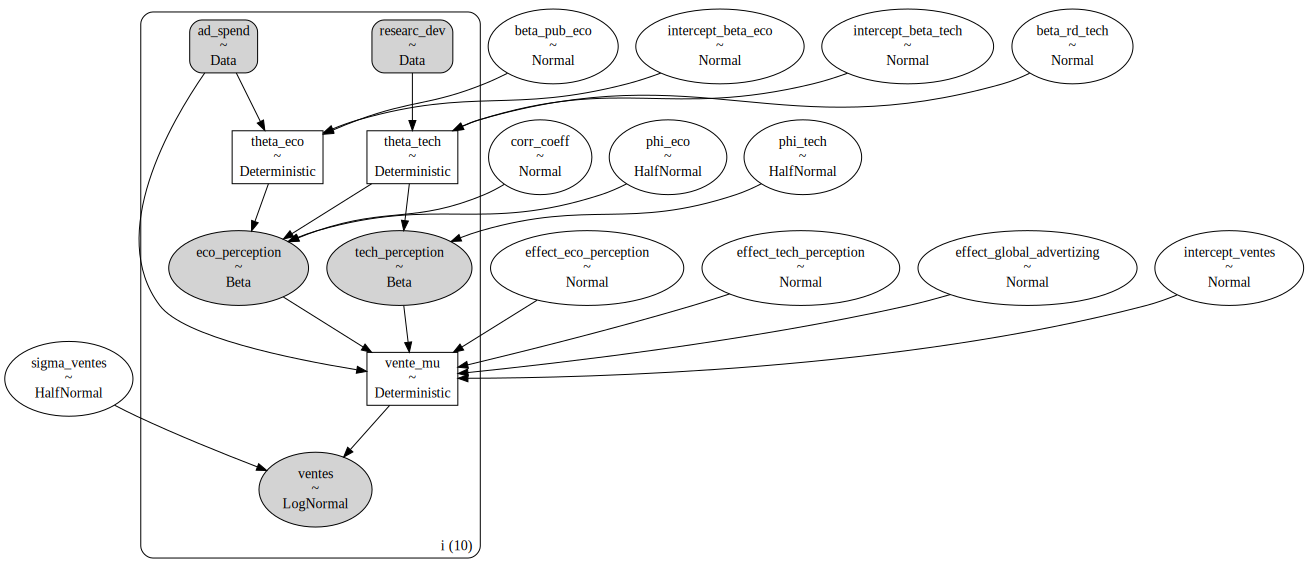

In [316]:
with pm.Model(coords={"i": np.arange(len(df_test))}) as model:
    # Define priors for parent nodes
    researc_dev = pm.Data('researc_dev', df_test["researc_dev"].values, dims="i")
    ad_spend = pm.Data('ad_spend', df_test["ad_spend"].values, dims="i")

    # Define the model parameters prior for the beta reg of R&D on tech.
    intercept_beta_tech = pm.Normal('intercept_beta_tech', mu=0, sigma=1)
    beta_rd_tech = pm.Normal('beta_rd_tech', mu=0, sigma=1)
    phi_tech = pm.HalfNormal('phi_tech', sigma=1)
    mu_tech = intercept_beta_tech + beta_rd_tech * researc_dev
    theta_tech = pm.Deterministic('theta_tech', pm.math.invlogit(mu_tech), dims="i")

    # Define the model parameters prior for the beta reg of pub on eco.
    intercept_beta_eco = pm.Normal('intercept_beta_eco', mu=0, sigma=1)
    beta_pub_eco = pm.Normal('beta_pub_eco', mu=0, sigma=1)
    phi_eco = pm.HalfNormal('phi_eco', sigma=1)
    mu_eco = intercept_beta_eco + beta_pub_eco * ad_spend
    theta_eco = pm.Deterministic('theta_eco', pm.math.invlogit(mu_eco), dims="i")

    # Correlation term between tech_perception and eco_perception
    corr_coeff = pm.Normal('corr_coeff', mu=0, sigma=1)

    # Define tech_perception and eco_perception with correlation
    tech_perception_mu = theta_tech
    eco_perception_mu = theta_eco + corr_coeff * tech_perception_mu

    # Likelihoods for observed data with added correlation term
    tech_perception = pm.Beta('tech_perception', alpha=tech_perception_mu * phi_tech, beta=(1 - tech_perception_mu) * phi_tech, observed=df_test["tech_perception"].values, dims="i")
    eco_perception = pm.Beta('eco_perception', alpha=eco_perception_mu * phi_eco, beta=(1 - eco_perception_mu) * phi_eco, observed=df_test["eco_perception"].values, dims="i")

    # Final sur les ventes
    intercept_ventes = pm.Normal('intercept_ventes', mu=0, sigma=1)
    effect_tech_perception = pm.Normal('effect_tech_perception', mu=0, sigma=1)
    effect_eco_perception = pm.Normal('effect_eco_perception', mu=0, sigma=1)
    effect_global_advertizing = pm.Normal('effect_global_advertizing', mu=0, sigma=1)
    sigma_ventes = pm.HalfNormal("sigma_ventes", sigma=1)
    vente_mu = pm.Deterministic("vente_mu", intercept_ventes + effect_tech_perception * tech_perception +
                                effect_eco_perception * eco_perception +
                                effect_global_advertizing * ad_spend, dims="i")
    ventes = pm.LogNormal("ventes", mu=vente_mu, sigma=sigma_ventes, observed=df_test["ventes"].values, dims="i")

# Visualiser le modèle
pm.model_to_graphviz(model)

In [317]:
with model:
    idata = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_beta_tech, beta_rd_tech, phi_tech, intercept_beta_eco, beta_pub_eco, phi_eco, corr_coeff, intercept_ventes, effect_tech_perception, effect_eco_perception, effect_global_advertizing, sigma_ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 423 seconds.
There were 1838 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


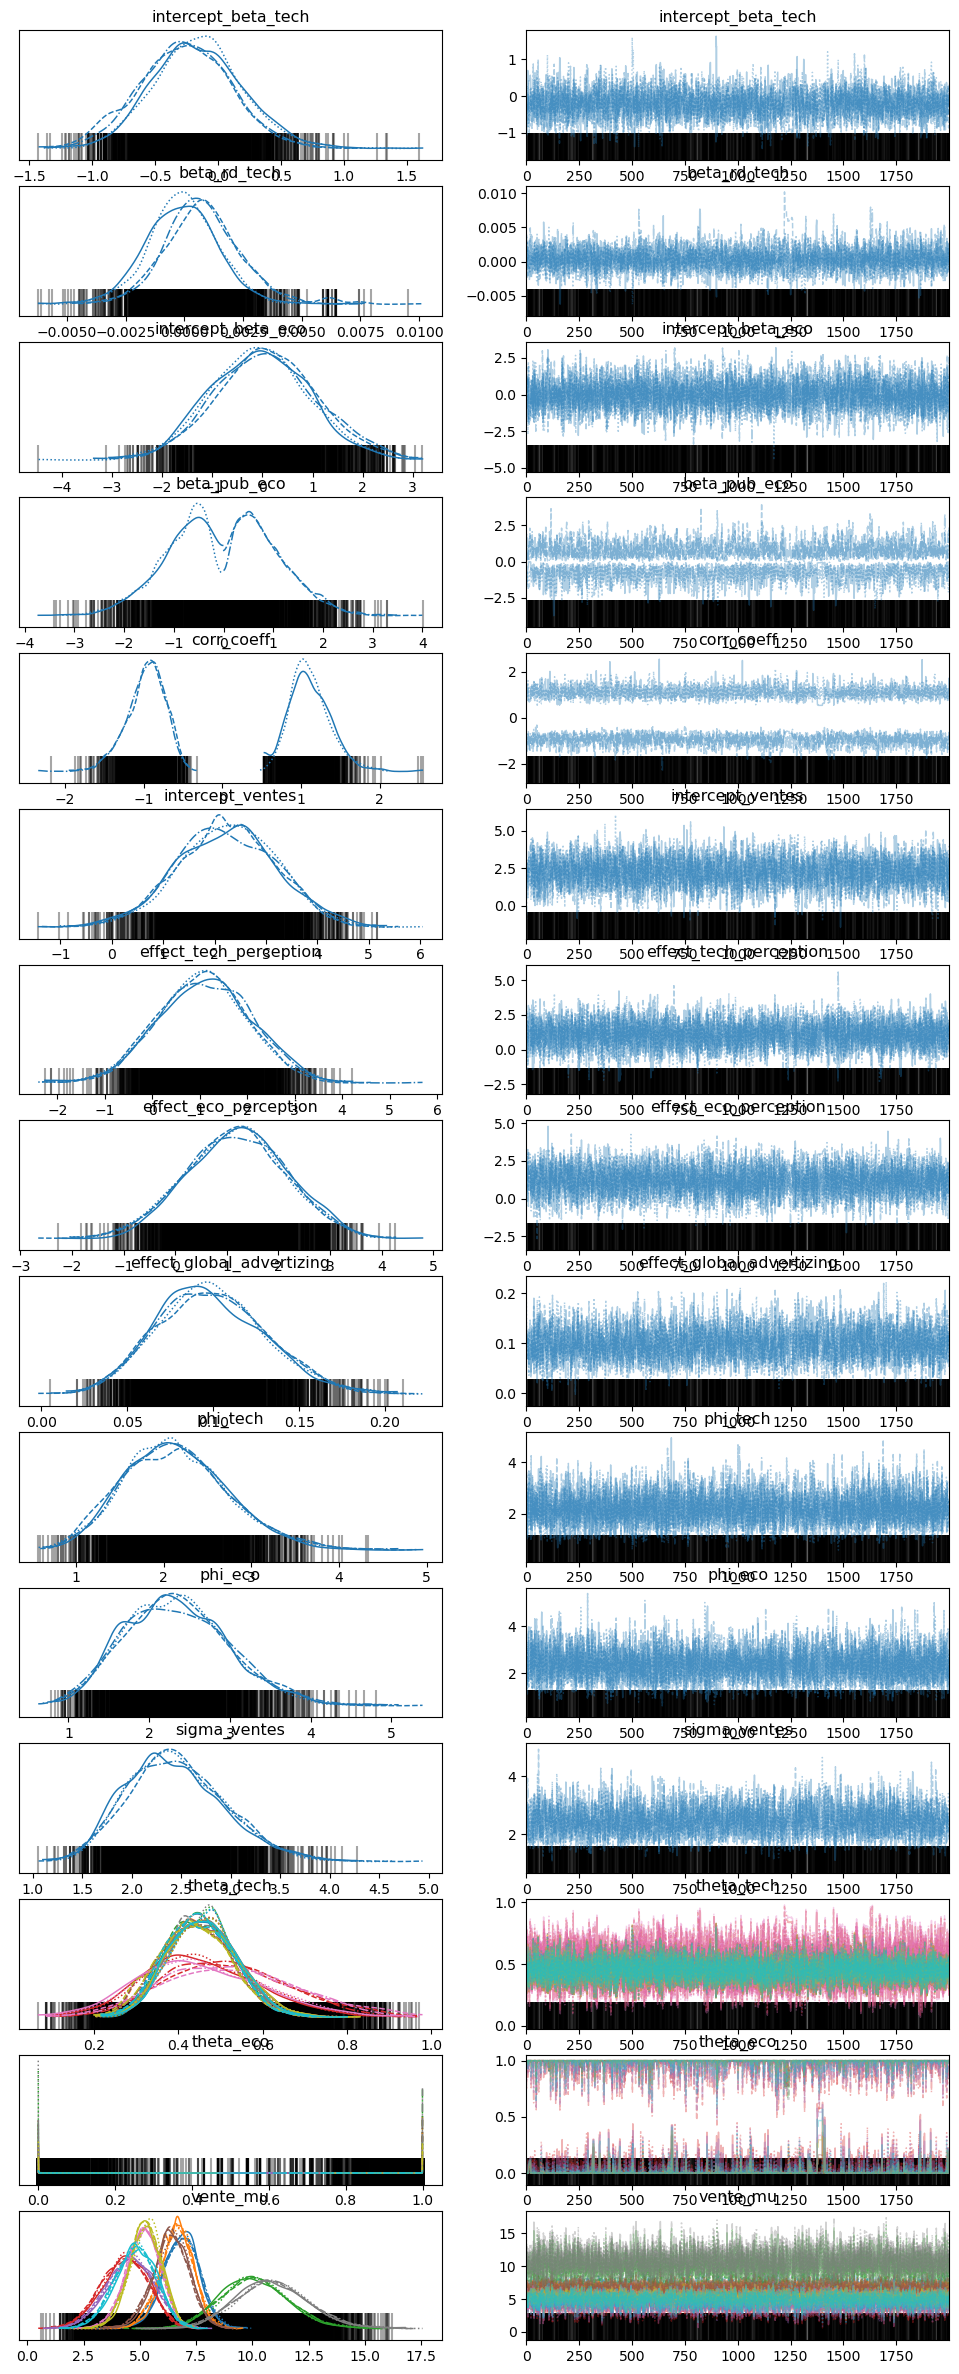

In [318]:
az.plot_trace(idata)
plt.show()


In [319]:
with model:
    # Générer des échantillons prédictifs postérieurs pour 'ventes'
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=["ventes"], random_seed=42)

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [326]:
# Nouvelles données pour les noeuds sans parents
researc_dev_downgrade = np.array([10, 12, 8, 9, 15, 18, 14, 89, 60, 13])  # Exemple de nouvelles données
ad_spend_downgrade = np.array([3, 5, 4, 6, 7, 2, 2, 8, 6, 7])         # Exemple de nouvelles données

# Mise à jour des valeurs pour les noeuds sans parents dans le modèle
with model:
    pm.set_data({"researc_dev": researc_dev_downgrade, "ad_spend": ad_spend_downgrade})
    # Générer des échantillons prédictifs pour les nouvelles données
    new_posterior_predictive_downgrade = pm.sample_posterior_predictive(idata, var_names=["tech_perception", "eco_perception","ventes"], random_seed=42)

# Accéder aux nouvelles prédictions pour 'ventes'
new_ventes_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["ventes"]
new_perception_eco_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["eco_perception"]
new_perception_tech_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["tech_perception"]

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: b <= 0
Apply node that caused the error: beta_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x14B7314F4C0>), MakeVector{dtype='int64'}.0, Composite{...}.2, Composite{...}.3)
Toposort index: 11
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,))]
Inputs shapes: ['No shapes', (1,), (10,), (10,)]
Inputs strides: ['No strides', (8,), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x14B7314F4C0, array([10], dtype=int64), 'not shown', 'not shown']
Outputs clients: [['output'], ['output', Composite{(i2 + (i5 * i6) + (i3 * i4) + (i0 * i1))}(ExpandDims{axis=0}.0, ad_spend, ExpandDims{axis=0}.0, ExpandDims{axis=0}.0, eco_perception, ExpandDims{axis=0}.0, tech_perception)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [321]:
ventes_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["ventes"]
ventes_pred_downgrade_array = ventes_pred_downgrade.values
ventes_pred_downgrade_flat = ventes_pred_downgrade_array.flatten()

perception_eco_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["eco_perception"]
perception_eco_pred_downgrade_array = perception_eco_pred_downgrade.values
perception_eco_pred_downgrade_flat = perception_eco_pred_downgrade_array.flatten()

perception_tech_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["tech_perception"]
perception_tech_pred_downgrade_array = perception_tech_pred_downgrade.values
perception_tech_pred_downgrade_flat = perception_tech_pred_downgrade_array.flatten()

In [322]:
# Nouvelles données pour les noeuds sans parents
researc_dev_cst = np.array([122, 122, 122, 122, 122, 122, 122, 122, 122, 122])  # Exemple de nouvelles données
ad_spend_cst = np.array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36])         # Exemple de nouvelles données

# Mise à jour des valeurs pour les noeuds sans parents dans le modèle
with model:
    pm.set_data({"researc_dev": researc_dev_cst, "ad_spend": ad_spend_cst})
    # Générer des échantillons prédictifs pour les nouvelles données
    new_posterior_predictive_cst = pm.sample_posterior_predictive(idata, var_names=["tech_perception", "eco_perception", "ventes"], random_seed=42)

# Accéder aux nouvelles prédictions pour 'ventes'
new_ventes_pred_cst = new_posterior_predictive_cst.posterior_predictive["ventes"]
new_perception_eco_pred_cst = new_posterior_predictive_cst.posterior_predictive["eco_perception"]
new_perception_tech_pred_cst = new_posterior_predictive_cst.posterior_predictive["tech_perception"]

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

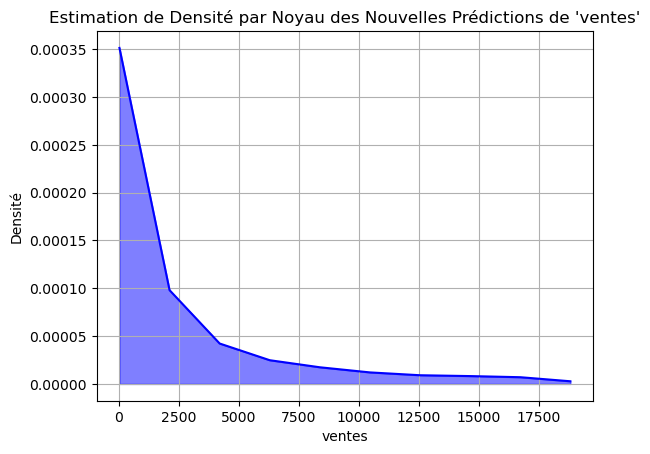

In [323]:
difference = ventes_pred_cst_flat - ventes_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='blue')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='blue')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'ventes'")
plt.xlabel("ventes")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

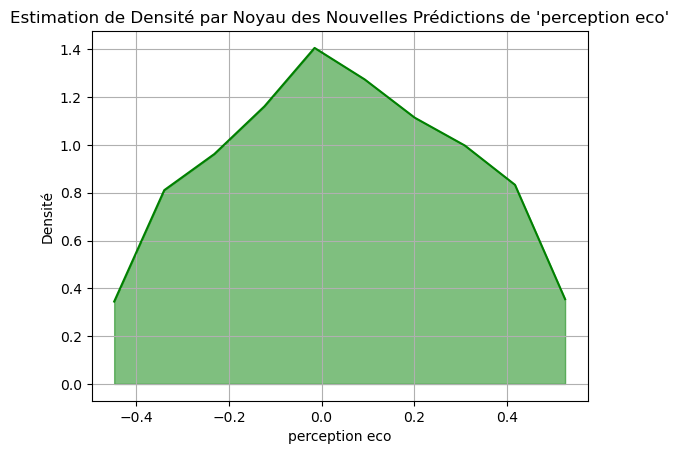

In [324]:
difference = perception_eco_pred_cst_flat - perception_eco_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='green')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='green')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'perception eco'")
plt.xlabel("perception eco")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

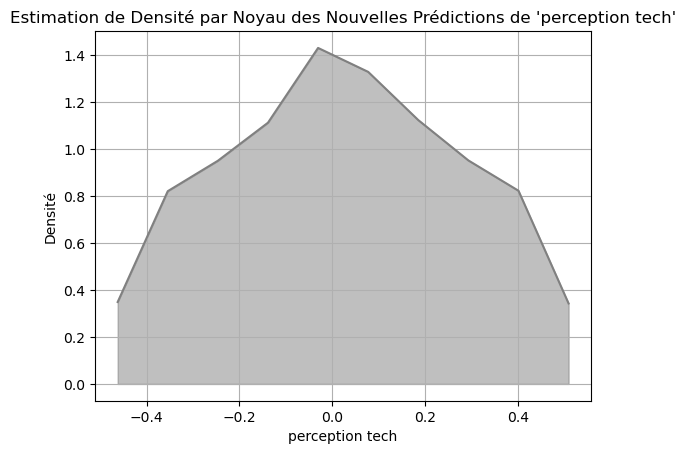

In [325]:
difference = perception_tech_pred_cst_flat - perception_tech_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='grey')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='grey')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'perception tech'")
plt.xlabel("perception tech")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

---
# Second model fitting to our use case naming

In [345]:
np.random.seed(123)
N = 10
df_test = pd.DataFrame({
    "image_item_1": np.random.lognormal(mean=3, sigma=2, size=N),
    "image_item_2": np.random.lognormal(mean=4, sigma=1, size=N),
    "image_item_3": np.random.lognormal(mean=2, sigma=1, size=N),
    "brand_consideration": np.random.beta(a=2, b=3, size=N),
    "preferences": np.random.beta(a=3, b=2, size=N),
    "sales": np.random.lognormal(mean=np.log(np.random.lognormal(mean=6, sigma=2, size=N)) + np.log(np.random.lognormal(mean=2, sigma=1, size=N)), sigma=0.5, size=N)
})

In [346]:
df_test['image_item_3_std'] = (df_test['image_item_3'] - df_test['image_item_3'].mean()) / df_test['image_item_3'].std()

In [347]:
df_test

,image_item_1,image_item_2,image_item_3,brand_consideration,preferences,sales,image_item_3_std
0,2.290428,27.691177,15.446286,0.865980,0.372331,2241.037827,0.399265
1,147.627306,49.664532,32.809957,0.570112,0.891670,15621.952774,1.984652
2,35.373289,242.594088,2.898421,0.195975,0.577245,745.674112,-0.746415
3,0.987489,28.820819,23.946664,0.245739,0.850927,15221.620970,1.175391
4,6.314190,35.023457,2.108801,0.674862,0.778660,6784.775891,-0.818511
5,546.138755,35.362386,3.904964,0.284362,0.803757,63491.939936,-0.654513
6,0.156710,495.679765,18.303736,0.764696,0.908191,993.304855,0.660164
7,8.517942,486.280729,1.770601,0.317015,0.389209,2410.364546,-0.849390
8,252.616497,149.016032,6.423295,0.169569,0.731624,1658.080081,-0.424577
9,3.548479,80.333474,3.121286,0.501987,0.710204,6102.410102,-0.726066


In [ ]:
# Bayesian Network
with pm.Model(coords={"i": np.arange(N)}) as model:
    # Define priors for parent nodes
    image_item_1 = pm.Data('image_item_1', df_test["image_item_1"].values, dims="i")
    image_item_2 = pm.Data('image_item_2', df_test["image_item_2"].values, dims="i")
    image_item_3 = pm.Data('image_item_3', df_test["image_item_3"].values, dims="i")

    # Define the model parameters prior for the beta reg of image 1 and image 3 on brand consideration.
    intercetp_beta_brand_consid = pm.Normal('intercetp_beta_brand_consid')
    beta_item_1 = pm.Normal('beta_item_1')
    beta_item_3 = pm.Normal('beta_item_3')
    phi_brand_consid = pm.HalfNormal('phi_brand_consid')
    mu_brand_consid = intercetp_beta_brand_consid + (beta_item_1 * image_item_1) + (beta_item_3 * image_item_3)
    theta_brand_consid = pm.Deterministic('theta_brand_consid', pm.math.invlogit(mu_brand_consid), dims="i")

    # Define the model parameters prior for the beta reg of image 2 and image 3 on preferences.
    intercetp_beta_pref = pm.Normal('intercetp_beta_pref')
    beta_item_2 = pm.Normal('beta_item_2')
    beta_item_3 = pm.Normal('beta_item_3')
    phi_pref = pm.HalfNormal('phi_pref')
    mu_pref = intercetp_beta_pref + (beta_item_2 * image_item_2) + (beta_item_3 * image_item_3)
    theta_pref = pm.Deterministic('theta_brand_consid', pm.math.invlogit(mu_pref), dims="i")

    # Beta likelihood for observed data y
    brand_consid_perception = pm.Beta('tech_perception', alpha=theta_brand_consid * phi_brand_consid, beta=(1 - theta_brand_consid) * phi_brand_consid, dims="i", 
                                      observed=df_test["brand_consideration"].values)
    pref_perception = pm.Beta('pref_perception', alpha=theta_pref * phi_pref, beta=(1 - theta_pref) * phi_pref, dims="i", 
                              observed=df_test["preferences"].values)

    # Final sur les ventes
    intercept_sales = pm.Normal('intercept_sales')
    effect_brand_consid_perception = pm.Normal('effect_brand_consid_perception')
    effect_pref_perception = pm.Normal('effect_pref_perception')
    effect_image_3 = pm.Normal('effect_image_3')
    sigma_sales = pm.HalfNormal("sigma_sales")
    sales_mu = pm.Deterministic("sales_mu", intercept_sales + (effect_brand_consid_perception * brand_consid_perception) +
                                (effect_pref_perception * pref_perception) +
                                (effect_image_3 * image_item_3), dims="i")
    sales = pm.LogNormal("sales", mu=sales_mu, sigma=sigma_sales, dims="i", observed=df_test["sales"].values)

pm.model_to_graphviz(model)